In [1]:
import numpy as np
import pandas as pd

# We'll use scipy.optimize.curve_fit to do the nonlinear regression
import scipy.optimize

import altair as alt

In [2]:
pwd

'/Users/michaelpiacentino/git/bootcamp'

In [3]:
!head data/bcd_gradient.csv

# Data taken from Fig. 3A of Driever and Nuesslein-Volhard, Cell,
# 54, 95-104, 1988.  This is the normalized immunostain intensity
# as a function of distance along the A-P axis in a wild type
# embryo.
fractional distance from anterior,[bcd] (a.u.)
0.0026446672455988007,0.86309692805632854
0.034222783610957611,0.86309692805632854
0.068445567221915221,0.74572710237919493
0.10262887818741613,0.65487479416273942
0.13420699455277493,0.54511384929873385


In [12]:
# Import data set
df = pd.read_csv('data/bcd_gradient.csv', comment='#')

# Inspect DataFrame
df.head()

,fractional distance from anterior,[bcd] (a.u.)
0,0.002645,0.863097
1,0.034223,0.863097
2,0.068446,0.745727
3,0.102629,0.654875
4,0.134207,0.545114


In [6]:
len(df)

28

In [13]:
# rename to get rid of brackets
df = df.rename(columns={'[bcd] (a.u.)': 'bcd'})
df.head()

,fractional distance from anterior,bcd
0,0.002645,0.863097
1,0.034223,0.863097
2,0.068446,0.745727
3,0.102629,0.654875
4,0.134207,0.545114


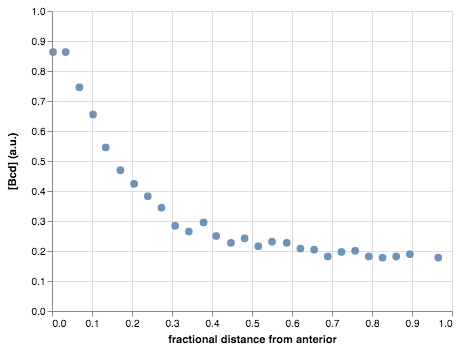

In [21]:
dots = alt.Chart(df
    ).mark_point(
        filled=True,
        size=60,
        opacity=0.8
    ).encode(
        x='fractional distance from anterior:Q',
        y=alt.Y('bcd:Q', 
                title='[Bcd] (a.u.)', 
                scale=alt.Scale(domain=[0, 1]))
    )

dots

We observe some noise and the staining intensity at the level of ~0.2 au

In [50]:
def bcd_gradient_model_first_try(x, I_0, a, lam):
    return a + I_0 * np.exp(-x/lam)
#but... we might have some errors, for example, we can't have a negative concentration and this won't check for that

In [51]:
def bcd_gradient_model(x, I_0, a, lam):
    if np.any(x < 0):
        raise RuntimeError('All values of "x" must be >= zero.')
    if np.any(np.array([I_0, a, lam]) < 0):
        raise RuntimeError('All parameters must be >= zero.')
        
    return a + I_0 * np.exp(-x/lam)

In [52]:
# Specify initial guesses
I_0_guess = 0.7
a_guess = 0.2
lam_guess = 1.0

p0 = np.array([I_0_guess, a_guess, lam_guess])
p0

array([0.7, 0.2, 1. ])

In [53]:
# If you put an underscore in Python means "I'm aware this will be assigned but I want to ignore it", and in this case
# we want to ignore the 2nd output of the function
popt, _ = scipy.optimize.curve_fit(bcd_gradient_model,
                                  df['fractional distance from anterior'],
                                  df['bcd'],
                                  p0=p0)

RuntimeError: All parameters must be >= zero.

In [54]:
# With our error message, it goes into the negative space which is impossible and gives us a RuntimeError

# If you put an underscore in Python means "I'm aware this will be assigned but I want to ignore it", and in this case
# we want to ignore the 2nd output of the function
popt, _ = scipy.optimize.curve_fit(bcd_gradient_model_first_try,
                                  df['fractional distance from anterior'],
                                  df['bcd'],
                                  p0=p0)
popt

array([0.76762162, 0.17423312, 0.18712895])

In [59]:
# However, if we use our test-free function, it gives us a result that's actually ok, but that works out for this data rather
# but other datasets might return a negative number
# Justin likes to write things in terms of the log of the parameters, because now they will be exponentiated into a 
# positive number and therefore safeguards against negatives

def bcd_gradient_model_log_params(x, log_I_0, log_a, log_lam):
    #Exponentiate the parameters
    I_0, a, lam = np.exp(np.array([log_I_0, log_a, log_lam]))
    
    return bcd_gradient_model(x, I_0, a, lam)

In [60]:
log_p0 = np.log(p0)

log_popt, _ = scipy.optimize.curve_fit(bcd_gradient_model_log_params,
                                      df['fractional distance from anterior'],
                                      df['bcd'],
                                      p0=log_p0)

popt = np.exp(log_popt)
popt

array([0.76762142, 0.17423289, 0.18712931])

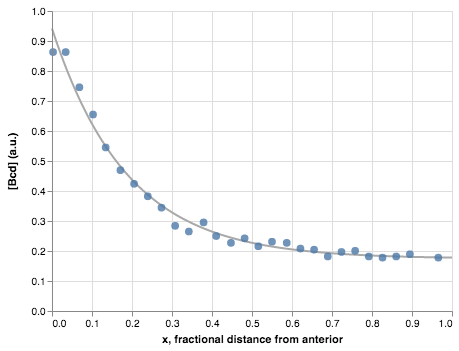

In [65]:
# Smooth x values (400 values between zero and one)
x_smooth = np.linspace(0, 1, 400)

# Compute smooth curve
bcd_smooth = bcd_gradient_model(x_smooth, *popt)

# Make into a data frame
df_smooth = pd.DataFrame({'x': x_smooth, 'bcd': bcd_smooth})

# Smooth line
line = alt.Chart(df_smooth
    ).mark_line(
        color='darkgray',
    ).encode(
        x='x',
        y='bcd')

line + dots 